<h1>KNN Exploration</h1>
This notebook will contain Erika's contribution to the assignment. To start with, Erika will look at using KNN on the Kickstarter data. If this proves uninteresting (and as time allows) Erika will also work on applying SVM to similar data.

In [63]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# For KNN stuff
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# For KNN scaling transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper

In [64]:
def load_preprocessed_data(name):
    # TODO: as additional preprocessing is completed, add options here.
    if name != 'base' and name != 'doc2vec':
        raise Exception("No preprocessd data available for that name.")
    x_train = pd.read_csv("data/preprocess-{}-x-train.csv".format(name), index_col=0)
    y_train = pd.read_csv("data/preprocess-{}-y-train.csv".format(name), squeeze=True)
    x_valid = pd.read_csv("data/preprocess-{}-x-valid.csv".format(name), index_col=0)
    y_valid = pd.read_csv("data/preprocess-{}-y-valid.csv".format(name), squeeze=True)
    return x_train, y_train, x_valid, y_valid
        

We want to run all of our algorithms - including KNN, in this notebook - on several different versions of preprocessed data. Load them all here.

In [65]:
x_train_base, y_train_base, x_valid_base, y_valid_base = load_preprocessed_data('base')
x_train_d2v, y_train_d2v, x_valid_d2v, y_valid_d2v = load_preprocessed_data('doc2vec')
# TODO: load addtional preprocessed data

In [66]:
print(len(x_train_base))
print(len(y_train_base))
x_train_base.head()

249956
249956


,main_category,category,duration,usd_goal_real,launched_month,deadline_month
0,12,19,-0.316333,-0.036515,4.0,5.0
2,8,136,2.025723,-0.031740,10.0,0.0
4,7,44,-0.272265,-0.032463,7.0,8.0
5,5,31,-0.400095,-0.034948,2.0,3.0
6,6,93,-0.326225,0.008140,0.0,2.0


In [67]:
print(len(x_train_d2v))
print(len(y_train_d2v))
x_train_d2v.head()

249956
249955


,main_category,category,duration,usd_goal_real,launched_month,deadline_month,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_0,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_1,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_2,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_3,...,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_10,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_11,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_12,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_13,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_14,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_15,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_15_doc2vec_names_16_doc2vec_names_17_doc2vec_names_18_doc2vec_names_19_16,doc2vec_names_0_doc2vec_names_1_doc2vec_names_2_doc2vec_names_3_doc2vec_names_4_doc2vec_names_5_doc2vec_names_6_doc2vec_names_7_doc2vec_names_8_doc2vec_names_9_doc2vec_names_10_doc2vec_names_11_doc2vec_names_12_doc2vec_names_13_doc2vec_names_14_doc2vec_names_1

In [68]:
y_train_base.head()

0     True
1     True
2    False
3    False
4    False
Name: success, dtype: bool

In [69]:
y_train_d2v.head()

0     True
1    False
2    False
3    False
4     True
Name: True, dtype: bool

In [53]:
def get_knn_mapper():
    mapper = DataFrameMapper([
        (['launched_month'], MinMaxScaler()),
        (['deadline_month'], MinMaxScaler()),
        (['category'], MinMaxScaler()),
        (['main_category'], MinMaxScaler()),
    ], df_out=True)
    return mapper

In [54]:
%%time
mapper = get_knn_mapper()
x_train_base_scaled = mapper.fit_transform(x_train_base)
x_valid_base_scaled = mapper.transform(x_valid_base)
x_train_d2v_scaled = mapper.fit_transform(x_train_d2v)
x_valid_d2v_scaled = mapper.transform(x_valid_d2v)

KeyError: "None of [Index(['launched_month'], dtype='object')] are in the [columns]"

In [55]:
x_train_base_scaled.head()

,launched_month,deadline_month,category,main_category
0,0.363636,0.454545,0.120253,0.857143
2,0.909091,0.000000,0.860759,0.571429
4,0.636364,0.727273,0.278481,0.500000
5,0.181818,0.272727,0.196203,0.357143
6,0.000000,0.181818,0.588608,0.428571


In [6]:
# Start by looking at scikit learn nearest neightbors
def try_knn(x_train, y_train, x_valid, y_valid, neighbors, weights, algorithm='auto'):
    knn = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, algorithm=algorithm, n_jobs=8)
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_valid)
    return knn, metrics.accuracy_score(y_valid, y_pred)

In [7]:
def get_scores(n_low, n_high, n_step, x_train, y_train, x_valid, y_valid, weights=['uniform', 'distance']):
    print("Calling 'get_scores'")
    max_score = (0, None, None, None)
    scores = {}
    for w in weights:
        print("Looking at weight measurement: {}".format(w))
        scores["{}".format(w)] = []
        for n in range(n_low, n_high + 1, n_step):
            knn, score = try_knn(x_train, y_train, x_valid, y_valid, neighbors=n, weights=w)
            if (n % 5 == 0):
                print("\tFor {: 3} neighbors, score: {}".format(n, score))
            scores["{}".format(w)].append((n, score))
            if max_score[0] < score:
                max_score = (score, w, n, knn)
    return max_score, scores

In [8]:
def plot_scores(scores):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']

    for i, (key, score_array) in enumerate(scores.items()):
        ns = [n for (n, _) in score_array]
        ss = [s for (_, s) in score_array]
        line, = ax.plot(ns, ss, color=colors[i])
        line.set_label(key)
    
    # Label axes
    ax.set(xlabel='Number of neighbors', ylabel='Score',
           title='A graph plotting number of neighbors and scores')

    ax.legend()
    plt.show()

<h3>Parameter Tuning and Scaling Checks</h3>
The below runs are to start tuning the numbers of neighbors, and also check to see if the MinMaxScaling was effective at all in increasing accuracy.

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.5688892899034558
	For  50 neighbors, score: 0.5887695870552497
	For  75 neighbors, score: 0.591386207103973
	For  100 neighbors, score: 0.595296099130801
	For  125 neighbors, score: 0.5970104364041023
	For  150 neighbors, score: 0.599777436915396
	For  175 neighbors, score: 0.59980751300791
	For  200 neighbors, score: 0.6001684261180787
	For  225 neighbors, score: 0.6007398718758459
	For  250 neighbors, score: 0.600800024060874
	For  275 neighbors, score: 0.6008301001533881
	For  300 neighbors, score: 0.600800024060874
	For  325 neighbors, score: 0.600800024060874
	For  350 neighbors, score: 0.600800024060874
	For  375 neighbors, score: 0.600800024060874
	For  400 neighbors, score: 0.600800024060874
	For  425 neighbors, score: 0.600800024060874
	For  450 neighbors, score: 0.600800024060874
	For  475 neighbors, score: 0.600800024060874
	For  500 neighbors, score: 0.600800024060874
	For  525 neighbor

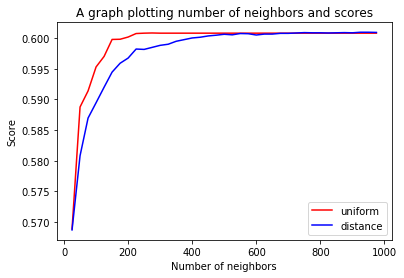

CPU times: user 19min 36s, sys: 3min 31s, total: 23min 8s
Wall time: 5min 53s


In [11]:
%%time
num_samples = 50000
max_score_base, scores_base = get_scores(25, 1000, 25, 
                                         x_train_base.head(num_samples), 
                                         y_train_base.head(num_samples), 
                                         x_valid_base.head(num_samples), 
                                         y_valid_base.head(num_samples))
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Calling 'get_scores'
Looking at weight measurement: uniform
	For  25 neighbors, score: 0.6318385515353845
	For  50 neighbors, score: 0.6342446389365094
	For  75 neighbors, score: 0.6313272579626454
	For  100 neighbors, score: 0.6272669854732473
	For  125 neighbors, score: 0.6230864086137929
	For  150 neighbors, score: 0.6213419952479774
	For  175 neighbors, score: 0.6199584949923306
	For  200 neighbors, score: 0.6169809618334386
	For  225 neighbors, score: 0.6112665042557671
	For  250 neighbors, score: 0.6134921351018076
	For  275 neighbors, score: 0.611747721735992
	For  300 neighbors, score: 0.6132515263616951
	For  325 neighbors, score: 0.6110258955156546
	For  350 neighbors, score: 0.6080784384492767
	For  375 neighbors, score: 0.6099431561851484
	For  400 neighbors, score: 0.6088904929471564
	For  425 neighbors, score: 0.6101236127402327
	For  450 neighbors, score: 0.6103942975728593
	For  475 neighbors, score: 0.6100333844626906
	For  500 neighbors, score: 0.6092514060573251
	For

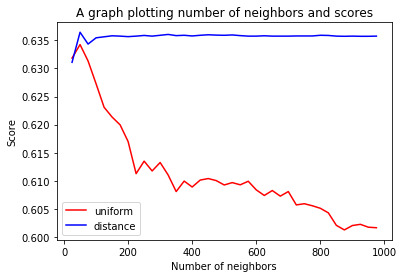

CPU times: user 27min 29s, sys: 3min 24s, total: 30min 54s
Wall time: 4min 23s


In [41]:
%%time
num_samples = 50000
max_score_base, scores_base = get_scores(25, 1000, 25, 
                                         x_train_base_scaled.head(num_samples), 
                                         y_train_base.head(num_samples), 
                                         x_valid_base_scaled.head(num_samples), 
                                         y_valid_base.head(num_samples))
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

<h3> Initial Results </h3>
MinMaxScaling appears to boost accuracy just a bit. Now that I've narrowed down a likely range for good values for neighbors, I'll do a more fine-grained search with all of the data. I've also seen that distance seems to work best, so I'll start only considering distance weights.

Calling 'get_scores'
Looking at weight measurement: distance
	For  60 neighbors, score: 0.6450118800565431
	For  65 neighbors, score: 0.6446208908538603
	For  70 neighbors, score: 0.6437787602634666
	For  75 neighbors, score: 0.6430268579506151
	For  80 neighbors, score: 0.643989292911065
	For  85 neighbors, score: 0.6438088363559806
	For  90 neighbors, score: 0.6447111191314024
	For  95 neighbors, score: 0.6451321844265993
	For  100 neighbors, score: 0.6457337062768805
	For  105 neighbors, score: 0.6454329453517399
	For  110 neighbors, score: 0.6457337062768805
	For  115 neighbors, score: 0.6458540106469367
	For  120 neighbors, score: 0.6462449998496196
	For  125 neighbors, score: 0.6462149237571054
	For  130 neighbors, score: 0.6463352281271617
	For  135 neighbors, score: 0.6461848476645914
	For  140 neighbors, score: 0.645974315016993
	For  145 neighbors, score: 0.6456735540918523
	For  150 neighbors, score: 0.6457637823693946
	For  155 neighbors, score: 0.6461547715720773
	For  160

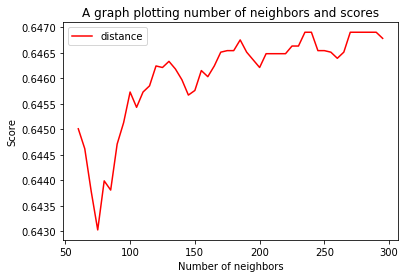

CPU times: user 12min 19s, sys: 2min 6s, total: 14min 26s
Wall time: 2min 22s


In [44]:
%%time
max_score_base, scores_base = get_scores(60, 300, 5, 
                                         x_train_base_scaled, 
                                         y_train_base, 
                                         x_valid_base_scaled, 
                                         y_valid_base,
                                        weights=['distance'])
print("The max score is: {} (w={}, n={})".format(max_score_base[0], max_score_base[1], max_score_base[2]))
plot_scores(scores_base)

Based on this initial result, the best score I'm seeing is:

The max score is: 0.6469066738849288 (w=distance, n=235)

Now, let's see if we can do better with the doc2vec preprocessed data.